In [1]:
# this embeds plots in the notebook
%matplotlib inline  

In [2]:
import numpy as np  # for arrays
import pylab as pl  # for plotting

In [3]:
import george
from george import kernels

In [4]:
indata = np.loadtxt("faraday_thin.txt")

In [5]:
nu = indata[0,:]
P_rg = indata[1,:]+1j*indata[2,:]

In [6]:
lam = 3e8/nu
lam_sq = (3e8/nu)**2

In [7]:
k1 = 1.0**2 * kernels.ExpSine2Kernel(2.0 / 1.0**2, 1.0)
k2 = kernels.WhiteKernel(0.01)
 
kernel = k1+k2

In [8]:
# first we feed our combined kernel to the George library:
gp = george.GP(kernel, mean=0.0)
 
# then we compute the covariance matrix:
gp.compute(lam_sq)

In [9]:
def nll(p):
 
    # Update the kernel parameters:
    gp.kernel[:] = p
 
    #  Compute the loglikelihood:
    ll_q = gp.lnlikelihood(P_rg.real, quiet=True)
    ll_u = gp.lnlikelihood(P_rg.imag, quiet=True)
    ll = ll_q + ll_u
    
    # The scipy optimizer doesn’t play well with infinities:
    return -ll if np.isfinite(ll) else 1e25

In [10]:
def grad_nll(p):
    
    # Update the kernel parameters:
    gp.kernel[:] = p
 
    #  Compute the gradient of the loglikelihood:
    gll_q = gp.grad_lnlikelihood(P_rg.real, quiet=True)
    gll_u = gp.grad_lnlikelihood(P_rg.imag, quiet=True)
    gll = gll_q + gll_u
 
    return -gll

In [17]:
import scipy.optimize as op
 
# extract our initial guess at parameters
# from the george kernel and put it in a
# vector:
p0 = gp.kernel.vector
 
# set prior ranges
# Note that these are in *logarithmic* space
bnds = ((-1.,2.),(-1.,2.),(-1.,1.),(-20.,-10.))
 
# run optimization:
results = op.minimize(nll, p0, method='L-BFGS-B', jac=grad_nll,bounds=bnds)

In [18]:
# pass the parameters to the george kernel:
gp.kernel[:] = results.x

In [19]:
t = np.arange(np.min(lam_sq),np.max(lam_sq),0.004)

# calculate expectation and variance at each point:
mu1, cov1 = gp.predict(P_rg.real, t)
std1 = np.sqrt(np.diag(cov1))

# calculate expectation and variance at each point:
mu2, cov2 = gp.predict(P_rg.imag, t)
std2 = np.sqrt(np.diag(cov2))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


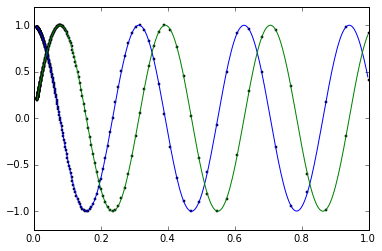

In [20]:
ax = pl.subplot(111)
pl.plot(t,mu1)
pl.plot(t,mu2)
ax.fill_between(t,mu1-std1,mu1+std1,facecolor='lightblue', lw=0, interpolate=True)
ax.fill_between(t,mu2-std2,mu2+std2,facecolor='lightblue', lw=0, interpolate=True)
pl.scatter(lam_sq,P_rg.real,s=3)
pl.scatter(lam_sq,P_rg.imag,s=3)
pl.axis([0,1,-1.2,1.2])
pl.show()

In [21]:
print np.exp(results.x)

[  2.71828185e+00   1.84603746e+00   9.42455350e-01   4.88375563e-07]


In [22]:
print results.x

[  1.00000001   0.61304143  -0.05926673 -14.53218113]
